#Text classification using CNN

Parameters of the task

In [1]:
# Task
max_words = 10000
max_len = 40
num_classes = 2

epochs = 10
batch_size = 512
print_batch_n = 100

datasets
https://github.com/madrugado/keras-tutorial

In [2]:
import pandas as pd

base_url = "https://github.com/madrugado/keras-tutorial/raw/master/data"
# base_url = "."
df_train = pd.read_csv(f"{base_url}/train.csv")
df_test = pd.read_csv(f"{base_url}/test.csv")
df_val = pd.read_csv(f"{base_url}/val.csv")

We can look at some examples from training set

In [3]:
df_train

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1
...,...,...,...
181462,181462,Классным будет новый год..( http://t.co/LejaGu...,0
181463,181463,Видишь человека хочешь сказать ему привет . А ...,0
181464,181464,@Julia6_9Styles там длинный диагноз. Вкратце: ...,0
181465,181465,"@technoslav ух ты, а кому тот серенький кнопоч...",1


## Preprocessing

Let's create a corpus of the text

In [4]:
train_text = df_train["text"].str.lower()

and find all tokents

In [6]:
import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from tqdm import tqdm
nltk.download("punkt")
nltk.download("punkt_tab")

# tokens = train_text.apply(word_tokenize).sum()

tokens = []
for text in tqdm(train_text):
    tokens += word_tokenize(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
100%|██████████| 181467/181467 [00:25<00:00, 7098.44it/s]


In [47]:
import re
def clean_raw_text(text: str) -> str:
    text = text.lower()
    # убираю тут ссылки
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # упоминания @user
    text = re.sub(r"@\w+", " ", text)
    # хэштеги
    text = re.sub(r"#", " ", text)
    # rt как отдельное слово (его оч много)
    text = re.sub(r"\brt\b", " ", text)
    return text.strip()

In [48]:
tokens = [clean_raw_text(i) for i in tokens]

Now filter ofnly numbers and words

In [50]:
tokens_filtered = [word for word in tokens if word.isalnum()]

Collect top N words in the corpus

In [52]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
dist = FreqDist(tokens_filtered)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
dist = FreqDist({k:v for k, v in dist.items() if k not in stop_words and len(k) > 1})

In [55]:
dist.pop('http', None)

26474

In [56]:
dist

FreqDist({'это': 15437, 'сегодня': 6960, 'хочу': 6015, 'очень': 5920, 'день': 5533, 'просто': 5408, 'тебе': 4571, 'завтра': 4318, 'вообще': 3835, 'всё': 3560, ...})

In [57]:
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

Let's looks at them

Now we are building vocabulary to encode every token using index

In [59]:
import pandas as pd
import numpy as np

vocabulary = pd.Series(index=tokens_filtered_top, data=np.arange(1, max_words))
vocabulary

,0
это,1
сегодня,2
хочу,3
очень,4
день,5
...,...
кода,9995
дочери,9996
ста,9997
воронеж,9998


In [ ]:
    tokens = [clean_raw_text(i) for i in tokens]
    tokens = [tok for tok in tokens if tok not in stop_words and len(tok) > 1]

In [90]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = pd.Series(word_tokenize(text.lower()))
    tokens = tokens.apply(clean_raw_text)
    mask = tokens.apply(lambda x: x not in stop_words and len(x) > 1)
    tokens = tokens[mask]
    tokens = tokens[tokens.str.isalnum()]
    tokens = tokens[tokens.isin(vocabulary.index)]
    result = vocabulary[tokens].to_list()
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [91]:
x_train = np.array([text_to_sequence(text, max_len) for text in tqdm(df_train["text"])], dtype=np.int32)
x_test = np.array([text_to_sequence(text, max_len) for text in tqdm(df_test["text"])], dtype=np.int32)
x_val = np.array([text_to_sequence(text, max_len) for text in tqdm(df_val["text"])], dtype=np.int32)

100%|██████████| 22683/22683 [01:23<00:00, 272.65it/s]


In [93]:
print(*df_train["text"].head(), sep='\n')

@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.
RT @GalyginVadim: Ребята и девчата!
Все в кино!!! "Вот Это Любовь!"
Сегодня! Завтра!  И потом!)))))
#вотэтолюбовь
RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT
RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :)
@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......))


In [94]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  435,  364,    1,  260,    2,    8],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 1272, 1017,  667],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

Let's prepare class labels

In [95]:
y_train = np.array(df_train["class"])
y_val = np.array(df_val["class"])

In [108]:
y_train[:10]

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1])

In [109]:
y_train.shape

(181467,)

## Network

In [110]:
import random
import torch
import torch.nn as nn


seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

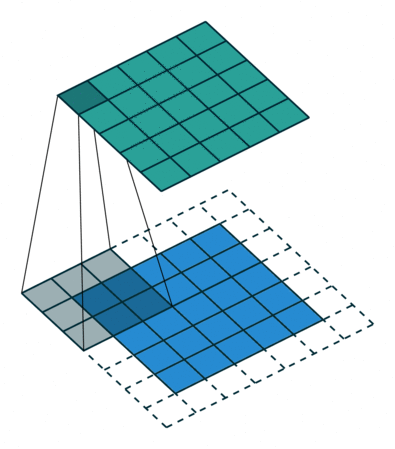

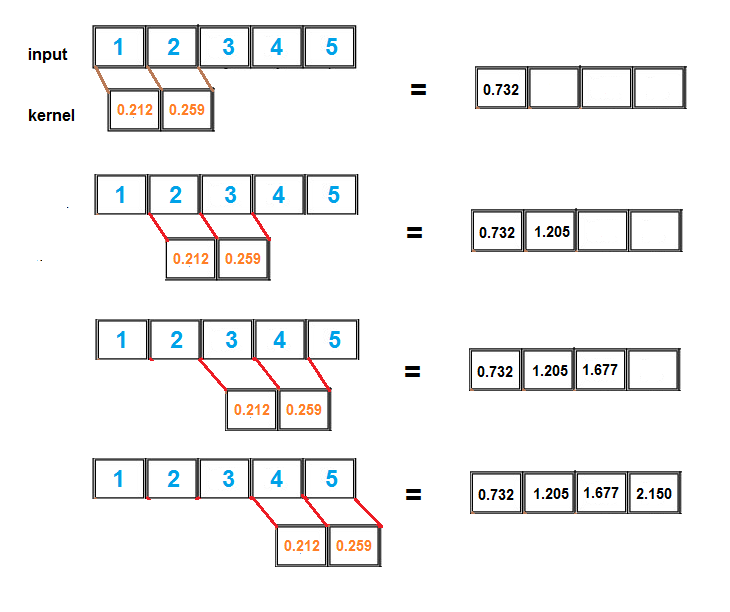

In [111]:
class Net(nn.Module):
    def __init__(self, vocab_size=max_words, embedding_dim = 128, out_channel = 128, num_classes = num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3,)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):       # [*, 40]
        # посл-сть индексов (вектор) -> посл-сть векторов (матрица)
        x = self.embedding(x)   # [*, 40, 128]
        # смена мест последних двух размерностей
        x = x.permute(0, 2, 1)  # [*, 128, 40] Conv1d в PyTorch ждёт формат [batch, channels, length].
        # применяем свёртку
        x = self.conv(x)        # [*, 128, 38]
        # накладываем нелинейность
        x = self.relu(x)        # [*, 128, 38]
        # берём максимум
        x = torch.max(x, axis=2).values # [*, 128] из всех фильтров беерм макс (не важно в какой позиции паттерн главное насколько сильно он выражен )
        # предсказываем
        x = self.linear(x)      # [*, 2]
        return x


## Training

In [112]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
          self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [113]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()


train_dataset = DataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1,epochs+1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        # compute output
        output = model(data)

        # compute gradient and do SGD step
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        if i % print_batch_n == 0:
            loss = loss.float().item()
            print(f"Step {i}: {loss=}")
            loss_history.append(loss)

Net(
  (embedding): Embedding(10000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 1329538
Train epoch 1/10
Step 0: loss=0.7098169326782227
Step 100: loss=0.6137603521347046
Step 200: loss=0.5866597890853882
Step 300: loss=0.5604758262634277
Train epoch 2/10
Step 0: loss=0.5088008642196655
Step 100: loss=0.5187281370162964
Step 200: loss=0.5395975708961487
Step 300: loss=0.5411709547042847
Train epoch 3/10
Step 0: loss=0.4408997893333435
Step 100: loss=0.4423253536224365
Step 200: loss=0.4651872515678406
Step 300: loss=0.447970986366272
Train epoch 4/10
Step 0: loss=0.40017831325531006
Step 100: loss=0.3930298686027527
Step 200: loss=0.35879358649253845
Step 300: loss=0.4450492560863495
Train epoch 5/10
Step 0: loss=0.268741250038147
Step 100: loss=0.27609649300575256
Step 200: loss=0.31736719608306885
Step 300: loss=0.31105419993400574
Train epoch 6/10
Step 0: loss=0.19144675

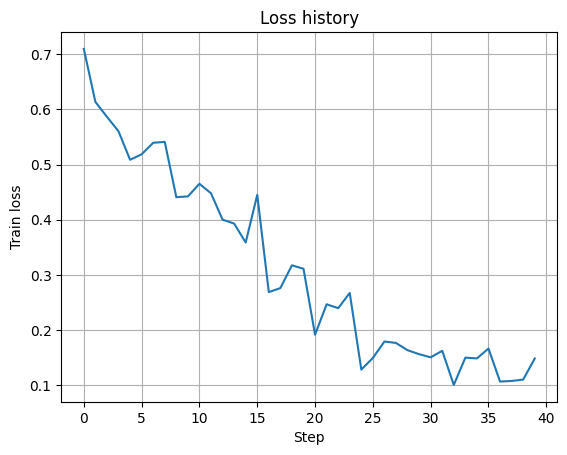

In [114]:
import matplotlib.pyplot as plt
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history)

In [115]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [116]:
model.eval()

pred = []
for i, (data, target) in enumerate(test_loader):
      data = data.to(device)
      # compute output
      output = model(data)
      output = torch.argmax(output, dim=1).detach().cpu()
      pred.extend(output.tolist())

In [117]:
pred[:10]

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1]

In [118]:
df_test[:10]

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."
5,204155,в Питере какой то Сайлент Хилл) http://t.co/gB...
6,204156,@Brokerrr2 ухты какой молодец)) ахаха) а ты со...
7,204157,"Мальчишки-кадеты, осталось детство где-то.))\n..."
8,204158,RT @MrFarneo: Было жутко больно :-/ http://t.c...
9,204159,Ромка что то раздобрел и купилмне киндер) Стра...


## Using pre-trained word2vec

## gensim

In [ ]:
import gensim.downloader as api
print(*api.info()['models'], sep='\n')

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
wv = api.load('glove-wiki-gigaword-50')

In [ ]:
vocab = pd.Series(wv.key_to_index) + 1
vocab

the                1
,                  2
.                  3
of                 4
to                 5
               ...  
chanty        399996
kronik        399997
rolonda       399998
zsombor       399999
sandberger    400000
Length: 400000, dtype: int64

In [ ]:
wv.vectors.shape

(400000, 50)

In [ ]:
wv_tensor = torch.from_numpy(wv.vectors)
wv_emb = torch.nn.Embedding.from_pretrained(wv_tensor, )
wv_emb

Embedding(400000, 50)

## fasttext

In [ ]:
%pip install -q fasttext

Creating new embedding weights from pre-trained model:

In [ ]:
def load_pretrained_vectors(word2idx, model):

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), model.get_dimension()))
    embeddings[word2idx['<pad>']] = np.zeros((model.get_dimension(),))

    count = 0
    for word, index in word2idx.items():
        embeddings[index] = model.get_word_vector(word)
        count += 1

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

Loading pre-trained fasttext model

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz .

--2024-03-11 13:56:01--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz     12%[=>                  ] 556.19M  77.5MB/s    eta 56s    ^C


In [ ]:
!gunzip cc.ru.300.bin.gz

In [ ]:
import fasttext.util
# fasttext.util.download_model('ru', if_exists='ignore')  # Russian
ft = fasttext.load_model('cc.ru.300.bin')

ft.get_word_vector('не')

In [ ]:
ft.get_nearest_neighbors('тюмень')

[(0.832332193851471, 'екатеринбург'),
 (0.7883850932121277, 'иркутск'),
 (0.7748076915740967, 'челябинск'),
 (0.7735596299171448, 'тверь'),
 (0.7704686522483826, 'тюмени'),
 (0.7691737413406372, 'казань'),
 (0.7625898718833923, 'оренбург'),
 (0.761424720287323, 'воронеж'),
 (0.7604470252990723, 'ульяновск'),
 (0.7570189237594604, 'томск')]

In [ ]:
import numpy as np

vocabulary['<pad>'] = 0
embeddings = load_pretrained_vectors(vocabulary, ft)

There are 10000 / 10000 pretrained vectors found.


Initializing model embedding matrix:

In [ ]:
new_model = Net(vocab_size=max_words, embedding_dim = 300)
new_model.embedding.weight.data.copy_(torch.tensor(embeddings))

tensor([[ 0.0114, -0.0257,  0.0245,  ..., -0.0323, -0.0474, -0.0325],
        [-0.0238,  0.0174, -0.0431,  ...,  0.1375, -0.1223, -0.2806],
        [ 0.0962, -0.0766, -0.0073,  ...,  0.0935, -0.4126, -0.1097],
        ...,
        [ 0.0281, -0.0593, -0.0590,  ..., -0.0229, -0.0192,  0.0152],
        [ 0.0427, -0.0328,  0.0313,  ...,  0.0106, -0.0517, -0.0375],
        [ 0.0274, -0.0345, -0.0449,  ..., -0.0400, -0.0066, -0.0266]])

### Task
Basing on the previous cell add code to infer your model for a particular input text.